In [2]:
# Data Processing Libraries
import pandas as pd
import os
import csv
import numpy as np
from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt

# Model Libraries 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras import regularizers

2023-12-12 01:25:41.314428: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Load Model Data 
Checkpoint: Load cached data here

In [3]:
# Test Loading Data
model_data_df = pickle.load(open('../data/model_data.pkl', 'rb'))
model_data_df

,race,sample_data,label
0,white,"[[0.0, 0.0010240421486530794, 1.0, 0.0, 0.0, 0...","Metaplastic carcinoma, NOS"
1,white,"[[0.0, 0.0010240421486530794, 1.0, 0.0, 0.0, 0...","Metaplastic carcinoma, NOS"
2,white,"[[0.0, 0.0010240421486530794, 1.0, 0.0, 0.0, 0...","Infiltrating duct carcinoma, NOS"
3,white,"[[0.0, 0.0010240421486530794, 1.0, 0.0, 0.0, 0...","Infiltrating duct carcinoma, NOS"
4,white,"[[0.0, 0.0010240421486530794, 1.0, 0.0, 0.0, 0...","Infiltrating duct carcinoma, NOS"
...,...,...,...
1495,not reported,"[[0.0, 0.0010240421486530794, 1.0, 0.0, 0.0, 0...","Infiltrating duct carcinoma, NOS"
1496,not reported,"[[0.0, 0.0010240421486530794, 1.0, 0.0, 0.0, 0...","Infiltrating duct carcinoma, NOS"
1497,black or african american,"[[0.0, 0.0010240421486530794, 1.0, 0.0, 0.0, 0...","Infiltrating duct carcinoma, NOS"
1498,black or african american,"[[0.0, 0.0010240421486530794, 1.0, 0.0, 0.0, 0...","Infiltrating duct carcinoma, NOS"


### Preprocess Data

In [4]:
# ONE HOT ENCODE DATA
encoded_labels = pd.get_dummies(model_data_df.label)
encoded_df = model_data_df.join(encoded_labels)


In [5]:
# Filter Data Frames by Race 
white_df = encoded_df[encoded_df["race"] == "white"]
black_df = encoded_df[encoded_df["race"] == "black or african american"]
asian_df = encoded_df[encoded_df["race"] == "asian"]
prognosis_names = encoded_df.label.unique()

# Train Test Split
def df_split(df): 
    split_index = int(0.7 * len(df)) 
    return df.iloc[:split_index], df.iloc[split_index:]

train_white_df, test_white_df = df_split(white_df) 
train_black_df, test_black_df = df_split(black_df) 
train_asian_df, test_asian_df = df_split(asian_df)

# Concatenate Final Sets 
train_df = train_white_df
# train_df = pd.concat([train_white_df, train_black_df, train_asian_df])

### DEFINE MODEL AND PREPARE DATA

In [6]:
# Prepare Model Data --> [takes 1 min. 15 sec.]
prognosis_names = encoded_df.label.unique()
def get_x_y(df): 
    x = np.stack(df.sample_data.values)
    y = df.filter(prognosis_names).values
    return x, y

def train_val_split(data):
    # returns: x_train, x_val, y_train, y_val
    x, y = data
    return train_test_split(x, y, test_size=0.15, random_state=42)


##### Main Code #########
x_train, x_val, y_train, y_val = train_val_split(get_x_y(train_df)) # training data

x_train_black, y_train_black = get_x_y(train_black_df)
x_train_asian, y_train_asian = get_x_y(train_asian_df)

x_test_white, y_test_white = get_x_y(test_white_df)
x_test_black, y_test_black = get_x_y(test_black_df)
x_test_asian, y_test_asian = get_x_y(test_asian_df)

In [7]:
# TRAIN NEURAL NETWORK
num_classes = model_data_df.label.nunique()

# Basic DNN Model 
reg_rate = 0.1
model = Sequential([
    Flatten(input_shape=(60623, 26)),  # Flattening the input
    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(reg_rate)),
    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(reg_rate)),
    Dense(num_classes, activation='softmax')  # Output layer with softmax for multi-class
])

def freeze_model(model): 
    model.trainable = False 
    model.layers[-1].trainable = True
    return model 


### Model Results for Freezing Last Layer

In [8]:
### RESULTS FOR BLACK / AA Patients 

# Reset and Compile the model
model.trainable = True
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train Initial Model 
print("---------------------- TRAIN ON WHITE DATA ----------------------")
history = model.fit(x_train, y_train, epochs=7, batch_size=32, validation_data=(x_val, y_val))

# Freeze model 
model = freeze_model(model)

# Transfer Learning 
print("---------------------- TRANSFER TO BLACK + AA DATA ----------------------")
history_continued = model.fit(x_train_black, y_train_black, epochs=15, initial_epoch=history.epoch[-1], batch_size=32, validation_split=0.2)

---------------------- TRAIN ON WHITE DATA ----------------------
Epoch 1/7
19/19 [==============================] - 28s 1s/step - loss: 74.1775 - accuracy: 0.4701 - val_loss: 28.8875 - val_accuracy: 0.5701
Epoch 2/7
19/19 [==============================] - 25s 1s/step - loss: 31.2560 - accuracy: 0.5515 - val_loss: 20.6352 - val_accuracy: 0.6916
Epoch 3/7
19/19 [==============================] - 24s 1s/step - loss: 22.6474 - accuracy: 0.5050 - val_loss: 19.6508 - val_accuracy: 0.4766
Epoch 4/7
19/19 [==============================] - 24s 1s/step - loss: 31.3284 - accuracy: 0.5150 - val_loss: 29.5137 - val_accuracy: 0.3364
Epoch 5/7
19/19 [==============================] - 23s 1s/step - loss: 29.7618 - accuracy: 0.4884 - val_loss: 23.3887 - val_accuracy: 0.6822
Epoch 6/7
19/19 [==============================] - 23s 1s/step - loss: 18.4961 - accuracy: 0.5997 - val_loss: 13.3867 - val_accuracy: 0.2617
Epoch 7/7
19/19 [==============================] - 23s 1s/step - loss: 16.7520 - accurac

In [9]:
# Check Test Performance - Black & AA Patients
evaluation = model.evaluate(x_test_black, y_test_black)

# 'evaluation' will contain the loss value and accuracy
loss = evaluation[0]
accuracy = evaluation[1]

print("Performance on Black Patients")
print("----------------------------------")
print(f"Loss on test data: {loss}")
print(f"Accuracy on test data: {accuracy}")


3/3 [==============================] - 0s 69ms/step - loss: 9.2002 - accuracy: 0.8333
Performance on Black Patients
----------------------------------
Loss on test data: 9.20019245147705
Accuracy on test data: 0.8333333134651184


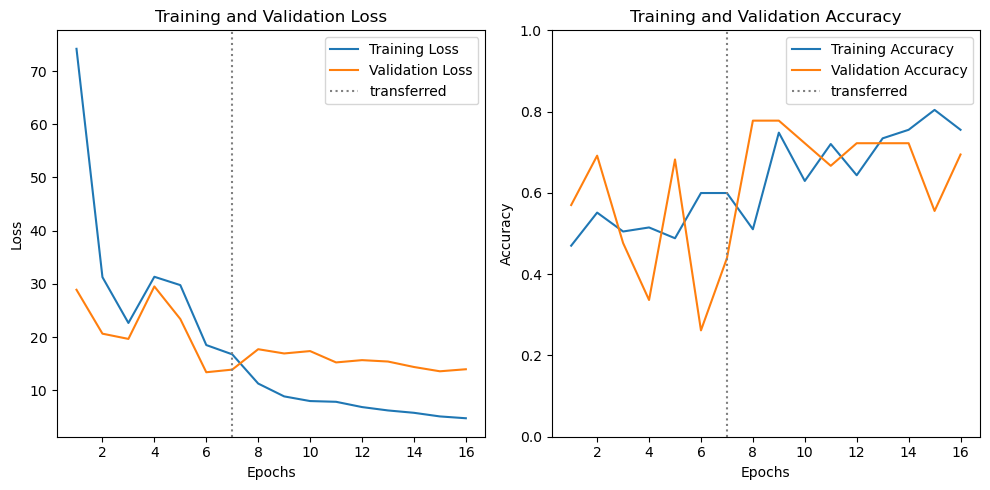

In [10]:
# PLOT MODEL PROGRESS

# Get training history
training_loss = history.history['loss'] + history_continued.history['loss']
training_accuracy = history.history['accuracy'] + history_continued.history['accuracy']
val_loss = history.history['val_loss'] + history_continued.history['val_loss']
val_accuracy = history.history['val_accuracy'] + history_continued.history['val_accuracy']
epochs = range(1, len(training_loss) + 1)

# Plotting loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, training_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.axvline(x = 7, color = 'gray', label = 'transferred', linestyle='dotted')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting accuracy
plt.subplot(1, 2, 2)
plt.ylim(0, 1) 
plt.plot(epochs, training_accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.axvline(x = 7, color = 'gray', label = 'transferred', linestyle='dotted')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [22]:
### RESULTS FOR Asian Patients 

# Reset and Compile the model
model.trainable = True
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train Initial Model 
print("---------------------- TRAIN ON WHITE DATA ----------------------")
history = model.fit(x_train, y_train, epochs=7, batch_size=32, validation_data=(x_val, y_val))

# Freeze model 
model = freeze_model(model)

# Transfer Learning 
print("---------------------- TRANSFER TO ASIAN DATA ----------------------")
history_continued = model.fit(x_train_asian, y_train_asian, epochs=15, initial_epoch=history.epoch[-1], batch_size=32, validation_split=0.2)

---------------------- TRAIN ON WHITE DATA ----------------------
Epoch 1/7
19/19 [==============================] - 28s 1s/step - loss: 38.5050 - accuracy: 0.4601 - val_loss: 17.5645 - val_accuracy: 0.6822
Epoch 2/7
19/19 [==============================] - 24s 1s/step - loss: 19.5325 - accuracy: 0.5764 - val_loss: 16.2571 - val_accuracy: 0.2336
Epoch 3/7
19/19 [==============================] - 24s 1s/step - loss: 11.0497 - accuracy: 0.5814 - val_loss: 6.6427 - val_accuracy: 0.4953
Epoch 4/7
19/19 [==============================] - 25s 1s/step - loss: 7.1528 - accuracy: 0.5980 - val_loss: 4.7391 - val_accuracy: 0.7103
Epoch 5/7
19/19 [==============================] - 23s 1s/step - loss: 3.9348 - accuracy: 0.6927 - val_loss: 3.7742 - val_accuracy: 0.4112
Epoch 6/7
19/19 [==============================] - 23s 1s/step - loss: 4.7041 - accuracy: 0.5100 - val_loss: 9.1129 - val_accuracy: 0.6822
Epoch 7/7
19/19 [==============================] - 23s 1s/step - loss: 6.4421 - accuracy: 0.573

In [23]:
# Check Test Performance - Asian Patients
evaluation = model.evaluate(x_test_asian, y_test_asian)

# 'evaluation' will contain the loss value and accuracy
loss = evaluation[0]
accuracy = evaluation[1]

print("Performance on Asian Patients")
print("----------------------------------")
print(f"Loss on test data: {loss}")
print(f"Accuracy on test data: {accuracy}")


1/1 [==============================] - 0s 235ms/step - loss: 2.8897 - accuracy: 0.8214
Performance on Asian Patients
----------------------------------
Loss on test data: 2.8896543979644775
Accuracy on test data: 0.8214285969734192


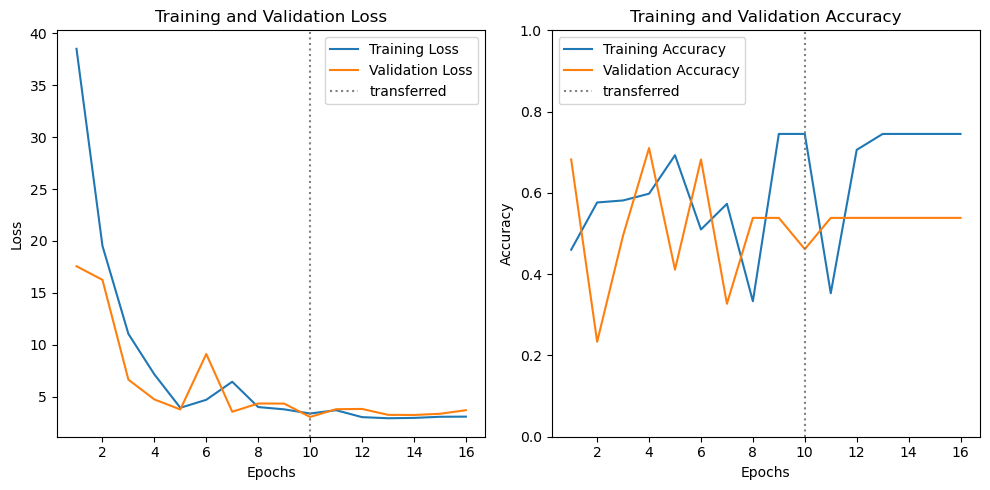

In [24]:
# PLOT MODEL PROGRESS

# Get training history
training_loss = history.history['loss'] + history_continued.history['loss']
training_accuracy = history.history['accuracy'] + history_continued.history['accuracy']
val_loss = history.history['val_loss'] + history_continued.history['val_loss']
val_accuracy = history.history['val_accuracy'] + history_continued.history['val_accuracy']
epochs = range(1, len(training_loss) + 1)

# Plotting loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, training_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.axvline(x = 7, color = 'gray', label = 'transferred', linestyle='dotted')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting accuracy
plt.subplot(1, 2, 2)
plt.ylim(0, 1) 
plt.plot(epochs, training_accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.axvline(x = 7, color = 'gray', label = 'transferred', linestyle='dotted')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### Model Results for just Fine Tuning

In [25]:
### RESULTS FOR BLACK / AA Patients 

# Reset and Compile the model
model.trainable = True
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train Initial Model 
print("---------------------- TRAIN ON WHITE DATA ----------------------")
history = model.fit(x_train, y_train, epochs=7, batch_size=32, validation_data=(x_val, y_val))

# Transfer Learning 
print("---------------------- TRANSFER TO BLACK + AA DATA ----------------------")
history_continued = model.fit(x_train_black, y_train_black, epochs=15, initial_epoch=history.epoch[-1], batch_size=32, validation_split=0.2)

---------------------- TRAIN ON WHITE DATA ----------------------
Epoch 1/7
19/19 [==============================] - 28s 1s/step - loss: 17.0862 - accuracy: 0.4801 - val_loss: 12.4994 - val_accuracy: 0.6822
Epoch 2/7
19/19 [==============================] - 24s 1s/step - loss: 10.5793 - accuracy: 0.5698 - val_loss: 6.7194 - val_accuracy: 0.2897
Epoch 3/7
19/19 [==============================] - 23s 1s/step - loss: 5.6808 - accuracy: 0.5316 - val_loss: 7.7652 - val_accuracy: 0.6822
Epoch 4/7
19/19 [==============================] - 23s 1s/step - loss: 6.7729 - accuracy: 0.5000 - val_loss: 4.9394 - val_accuracy: 0.6822
Epoch 5/7
19/19 [==============================] - 23s 1s/step - loss: 4.5241 - accuracy: 0.5947 - val_loss: 3.5043 - val_accuracy: 0.6822
Epoch 6/7
19/19 [==============================] - 23s 1s/step - loss: 2.9589 - accuracy: 0.6495 - val_loss: 2.4575 - val_accuracy: 0.6822
Epoch 7/7
19/19 [==============================] - 24s 1s/step - loss: 2.2896 - accuracy: 0.6794 

In [26]:
# Check Test Performance - Black & AA Patients
evaluation = model.evaluate(x_test_black, y_test_black)

# 'evaluation' will contain the loss value and accuracy
loss = evaluation[0]
accuracy = evaluation[1]

print("Performance on Black Patients")
print("----------------------------------")
print(f"Loss on test data: {loss}")
print(f"Accuracy on test data: {accuracy}")


3/3 [==============================] - 0s 70ms/step - loss: 1.7837 - accuracy: 0.7821
Performance on Black Patients
----------------------------------
Loss on test data: 1.7836865186691284
Accuracy on test data: 0.7820512652397156


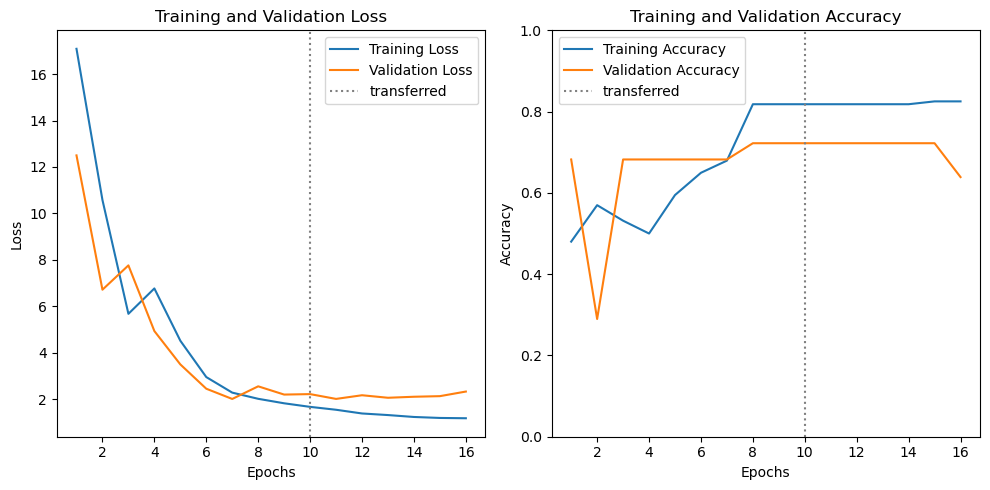

In [27]:
# PLOT MODEL PROGRESS

# Get training history
training_loss = history.history['loss'] + history_continued.history['loss']
training_accuracy = history.history['accuracy'] + history_continued.history['accuracy']
val_loss = history.history['val_loss'] + history_continued.history['val_loss']
val_accuracy = history.history['val_accuracy'] + history_continued.history['val_accuracy']
epochs = range(1, len(training_loss) + 1)

# Plotting loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, training_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.axvline(x = 7, color = 'gray', label = 'transferred', linestyle='dotted')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting accuracy
plt.subplot(1, 2, 2)
plt.ylim(0, 1) 
plt.plot(epochs, training_accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.axvline(x = 7, color = 'gray', label = 'transferred', linestyle='dotted')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [28]:
### RESULTS FOR Asian Patients 

# Reset and Compile the model
model.trainable = True
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train Initial Model 
print("---------------------- TRAIN ON WHITE DATA ----------------------")
history = model.fit(x_train, y_train, epochs=7, batch_size=32, validation_data=(x_val, y_val))

# Transfer Learning 
print("---------------------- TRANSFER TO ASIAN DATA ----------------------")
history_continued = model.fit(x_train_asian, y_train_asian, epochs=15, initial_epoch=history.epoch[-1], batch_size=32, validation_split=0.2)

---------------------- TRAIN ON WHITE DATA ----------------------
Epoch 1/7
19/19 [==============================] - 29s 1s/step - loss: 25.3084 - accuracy: 0.4718 - val_loss: 16.8860 - val_accuracy: 0.2150
Epoch 2/7
19/19 [==============================] - 24s 1s/step - loss: 10.0091 - accuracy: 0.5199 - val_loss: 6.2437 - val_accuracy: 0.6822
Epoch 3/7
19/19 [==============================] - 23s 1s/step - loss: 6.0168 - accuracy: 0.5648 - val_loss: 4.3117 - val_accuracy: 0.6822
Epoch 4/7
19/19 [==============================] - 23s 1s/step - loss: 4.3235 - accuracy: 0.6279 - val_loss: 3.5579 - val_accuracy: 0.4299
Epoch 5/7
19/19 [==============================] - 30s 2s/step - loss: 2.6731 - accuracy: 0.6528 - val_loss: 2.0878 - val_accuracy: 0.7009
Epoch 6/7
19/19 [==============================] - 30s 2s/step - loss: 2.3835 - accuracy: 0.6096 - val_loss: 2.5263 - val_accuracy: 0.6916
Epoch 7/7
19/19 [==============================] - 25s 1s/step - loss: 2.7090 - accuracy: 0.5864 

In [29]:
# Check Test Performance - Asian Patients
evaluation = model.evaluate(x_test_asian, y_test_asian)

# 'evaluation' will contain the loss value and accuracy
loss = evaluation[0]
accuracy = evaluation[1]

print("Performance on Asian Patients")
print("----------------------------------")
print(f"Loss on test data: {loss}")
print(f"Accuracy on test data: {accuracy}")


1/1 [==============================] - 0s 235ms/step - loss: 1.3618 - accuracy: 0.8214
Performance on Asian Patients
----------------------------------
Loss on test data: 1.3617624044418335
Accuracy on test data: 0.8214285969734192


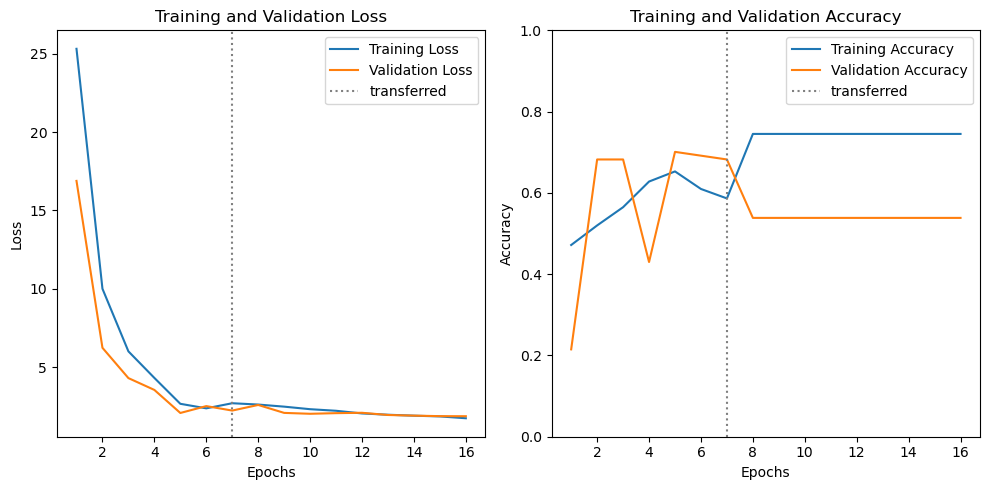

In [32]:
# PLOT MODEL PROGRESS

# Get training history
training_loss = history.history['loss'] + history_continued.history['loss']
training_accuracy = history.history['accuracy'] + history_continued.history['accuracy']
val_loss = history.history['val_loss'] + history_continued.history['val_loss']
val_accuracy = history.history['val_accuracy'] + history_continued.history['val_accuracy']
epochs = range(1, len(training_loss) + 1)

# Plotting loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, training_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.axvline(x = 7, color = 'gray', label = 'transferred', linestyle='dotted')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting accuracy
plt.subplot(1, 2, 2)
plt.ylim(0, 1) 
plt.plot(epochs, training_accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.axvline(x = 7, color = 'gray', label = 'transferred', linestyle='dotted')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()